# Capstone 2: Traditional vs. Non-traditional burial (Burials and Cremations)

**Context**

Amidst the current battle against covid-19, where there have been 3.9 million deaths globally and 128,162 reported deaths in the UK, one wonders what happened to these bodies.

Burials as well as cemetary upkeep are very costly, both fiscally and environmentally. Average funeral costs vary depending on the region in the UK; in South West of England funeral costs are around £4,500 while in London it's roughly £6,000. Cremations on average cost around £3,000-£4,000. Traditional burial, which includes basic coffin, hearse, collection and care of loved one, and a funeral director comes at about £5,000. The funeral director alone covers 50-60% of total cost of a funeral - so approximately £2,500. Other amenities and services have additional costs (Farewill).   An average cremation uses 92 cubic metres of natural gas - about 400 kg of CO2, equivalent to a 500 miles car trip. Cremations also release toxic gases like dioxins, PCDFs, and mercury. Most coffins used in the UK for cremations are made from chipboard or MDF that release harmful nitric oxide and nitrogen dioxide when burned. Materials used for burials cannot be reused and most items won't decompose for decades. Lastly, it is unlikely or at least difficult to convert cemeteries to woodland or pasture and cities are running out of space for cemeteries (a quarter of England's cemeteries are expected to be full by 2023) (Thinkwillow.com).

Here, I explore the growth and demand for cemeteries in the UK and look at data for traditional and non-traditional burial and see if there is an increasing trend in alternative burial investment. As a side note, according to a funerals market study by the Competition & Markets Authority (CMA), there are only two authorized approaches to body disposal: cremation and burial (either in a cemetery or natural burial ground). 

Precaution: “It is difficult to forecast accurately the future revenue and profitability of funeral directors and crematoria operators. This has significant ramifications for the design and implementation of price controls as a possible remedy.” - CMA

1. Import libraries

In [132]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import PyPDF2
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm 
import scipy.stats
import scipy.optimize
import scipy.spatial
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import linear_model, preprocessing 
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from numpy import mean


%matplotlib inline

### Part 1: Analyzing Covid cases in the UK

One of main goals of this capstone is to investigate how the covid-19 pandemic has affected funeral services and end-of-life body disposition in the UK, so we are looking at data from 2020 to 2021 (present) specifically. Here is data from the Office for National Statistics which includes number of deaths from districts across England, and cause of death recorded as either from Covid-19 or other causes. This data is from 2020. 

In [120]:
path = r'C:\Users\yuvem\Downloads\weekly-deaths-local-authority-2020-v1.xlsx'
xl = pd.read_excel(path)
xl.head()

,Geography,Geography code,Week,CauseOfDeath,PlaceOfDeath,RegistrationOrOccurrence,2020
0,Adur,E07000223,Week 01,All causes,Care home,Occurrences,2
1,Adur,E07000223,Week 01,All causes,Care home,Registrations,1
2,Adur,E07000223,Week 01,All causes,Elsewhere,Occurrences,0
3,Adur,E07000223,Week 01,All causes,Elsewhere,Registrations,0
4,Adur,E07000223,Week 01,All causes,Home,Occurrences,2


In [133]:
xl.isna().sum() # Check null-values

Geography                   0
Geography code              0
Week                        0
CauseOfDeath                0
PlaceOfDeath                0
RegistrationOrOccurrence    0
2020                        0
dtype: int64

In [134]:
# Check values
xl['CauseOfDeath'].unique()

array(['All causes', 'COVID 19'], dtype=object)

In [135]:
# Create a subset with columns CauseofDeath and 2020
xl_ = xl[['CauseOfDeath', '2020']]
xl_.head()

,CauseOfDeath,2020
0,All causes,2
1,All causes,1
2,All causes,0
3,All causes,0
4,All causes,2


In [136]:
xl_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419309 entries, 0 to 419308
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   CauseOfDeath  419309 non-null  object
 1   2020          419309 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [137]:
# Check values
xl_['CauseOfDeath'].unique()

array(['All causes', 'COVID 19'], dtype=object)

In [138]:
# Only COVID19
xl_subset1 = xl_[xl_['CauseOfDeath'] != 'All causes']
xl_subset1['CauseOfDeath'].unique()

array(['COVID 19'], dtype=object)

In [139]:
# Get total number of cases of COVID in 2020 from column 2020
covid_sum = xl_subset1['2020'].sum()
print(covid_sum)

156794


In [140]:
# Subset for only All causes
xl_subset2 = xl_[xl_['CauseOfDeath'] != 'COVID 19']
xl_subset2.head()

,CauseOfDeath,2020
0,All causes,2
1,All causes,1
2,All causes,0
3,All causes,0
4,All causes,2


In [141]:
# Get total number of cases of COVID in 2020 from column 2020
othercauses_sum = xl_subset2['2020'].sum()
print(othercauses_sum)

1183186


In [142]:
# Percentage of COVID
(covid_sum/othercauses_sum)*100

13.251847131389315

So about 13% of deaths were caused by Covid19 in 2020 in the UK. We could make a visualization of this.

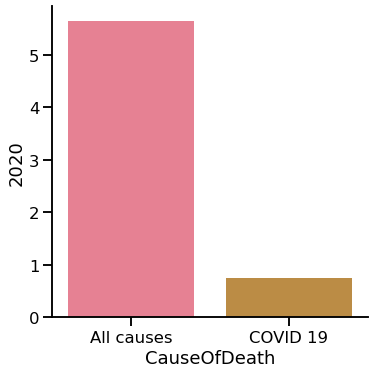

In [143]:
sns.catplot(x="CauseOfDeath", y="2020", data=xl, kind="bar", ci=None, estimator=mean)
plt.show()

### Part 2: Analyzing burial vs cremation 

The data here is published by Calderdale Metropolitan Borough Council, which contains public health funeral records in West Yorkshire, England. Public health funerals, acoording to the publisher and data.gov.uk, are arranged by local authorities for those who have died and have no known relatives to arrange or pay for their funeral or have relatives who do not wish to pay or these people are unable to arrange their funeral. 

In [2]:
path = r'C:\Users\yuvem\Downloads\publichealthfunerals_11_19.xlsx' # read excel file
xl = pd.read_excel(path)
xl.head()

,Year,First Name (2019 onwards),Second Name (2019 onwards),Date of Birth,Date of Death,Age at Death,Gender,Next of Kin,Cost of Funeral in pounds (Dec 2017 onwards only),Cost to LA in pounds,Cremation or Burial,Date of Funeral (2019 onward),Last known address/Place of death (2019 onwards)
0,2011-2012,NaN,NaN,25.06.1957,05.04.2011,53,Male,No,NaN,214,Crem,NaN,NaN
1,2011-2012,NaN,NaN,28.09.1925,11.05.2011,85,Female,Yes,NaN,nil,Crem,NaN,NaN
2,2011-2012,NaN,NaN,12.07.1971,18.08.2011,40,Male,No,NaN,1002,Crem,NaN,NaN
3,2011-2012,NaN,NaN,30.09.1927,22.09.2011,83,Male,No,NaN,Nil,Crem,NaN,NaN
4,2011-2012,NaN,NaN,02.07.1948,21.12.2011,63,Male,Yes,NaN,150,Crem,NaN,NaN


In [3]:
xl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 13 columns):
 #   Column                                             Non-Null Count  Dtype 
---  ------                                             --------------  ----- 
 0   Year                                               83 non-null     object
 1   First Name (2019 onwards)                          3 non-null      object
 2   Second Name (2019 onwards)                         3 non-null      object
 3   Date of Birth                                      83 non-null     object
 4   Date of Death                                      83 non-null     object
 5   Age at Death                                       83 non-null     int64 
 6   Gender                                             83 non-null     object
 7   Next of Kin                                        83 non-null     object
 8   Cost of Funeral in pounds (Dec 2017 onwards only)  23 non-null     object
 9   Cost to LA in pounds   

### Part 2a: Cleaning

In [4]:
df_tidy = xl.drop(columns="First Name (2019 onwards)") # delete this column because too many NaN values and would leave us with only 3 to look at
df_tidy.head()

,Year,Second Name (2019 onwards),Date of Birth,Date of Death,Age at Death,Gender,Next of Kin,Cost of Funeral in pounds (Dec 2017 onwards only),Cost to LA in pounds,Cremation or Burial,Date of Funeral (2019 onward),Last known address/Place of death (2019 onwards)
0,2011-2012,NaN,25.06.1957,05.04.2011,53,Male,No,NaN,214,Crem,NaN,NaN
1,2011-2012,NaN,28.09.1925,11.05.2011,85,Female,Yes,NaN,nil,Crem,NaN,NaN
2,2011-2012,NaN,12.07.1971,18.08.2011,40,Male,No,NaN,1002,Crem,NaN,NaN
3,2011-2012,NaN,30.09.1927,22.09.2011,83,Male,No,NaN,Nil,Crem,NaN,NaN
4,2011-2012,NaN,02.07.1948,21.12.2011,63,Male,Yes,NaN,150,Crem,NaN,NaN


In [5]:
df_tidier = df_tidy.drop(columns="Second Name (2019 onwards)") # delete this column too
df_tidier.head()

,Year,Date of Birth,Date of Death,Age at Death,Gender,Next of Kin,Cost of Funeral in pounds (Dec 2017 onwards only),Cost to LA in pounds,Cremation or Burial,Date of Funeral (2019 onward),Last known address/Place of death (2019 onwards)
0,2011-2012,25.06.1957,05.04.2011,53,Male,No,NaN,214,Crem,NaN,NaN
1,2011-2012,28.09.1925,11.05.2011,85,Female,Yes,NaN,nil,Crem,NaN,NaN
2,2011-2012,12.07.1971,18.08.2011,40,Male,No,NaN,1002,Crem,NaN,NaN
3,2011-2012,30.09.1927,22.09.2011,83,Male,No,NaN,Nil,Crem,NaN,NaN
4,2011-2012,02.07.1948,21.12.2011,63,Male,Yes,NaN,150,Crem,NaN,NaN


Let's delete more columns with too many NaN values.

In [6]:
df_tidier_ = df_tidier.drop(columns="Cost of Funeral in pounds (Dec 2017 onwards only)") # and this
df_tidier_.head()

,Year,Date of Birth,Date of Death,Age at Death,Gender,Next of Kin,Cost to LA in pounds,Cremation or Burial,Date of Funeral (2019 onward),Last known address/Place of death (2019 onwards)
0,2011-2012,25.06.1957,05.04.2011,53,Male,No,214,Crem,NaN,NaN
1,2011-2012,28.09.1925,11.05.2011,85,Female,Yes,nil,Crem,NaN,NaN
2,2011-2012,12.07.1971,18.08.2011,40,Male,No,1002,Crem,NaN,NaN
3,2011-2012,30.09.1927,22.09.2011,83,Male,No,Nil,Crem,NaN,NaN
4,2011-2012,02.07.1948,21.12.2011,63,Male,Yes,150,Crem,NaN,NaN


In [7]:
df_cleanmore = df_tidier_.drop(columns="Date of Funeral (2019 onward)") # and this
df_cleanmore.head()

,Year,Date of Birth,Date of Death,Age at Death,Gender,Next of Kin,Cost to LA in pounds,Cremation or Burial,Last known address/Place of death (2019 onwards)
0,2011-2012,25.06.1957,05.04.2011,53,Male,No,214,Crem,NaN
1,2011-2012,28.09.1925,11.05.2011,85,Female,Yes,nil,Crem,NaN
2,2011-2012,12.07.1971,18.08.2011,40,Male,No,1002,Crem,NaN
3,2011-2012,30.09.1927,22.09.2011,83,Male,No,Nil,Crem,NaN
4,2011-2012,02.07.1948,21.12.2011,63,Male,Yes,150,Crem,NaN


In [8]:
df_soclean = df_cleanmore.drop(columns="Last known address/Place of death (2019 onwards)") # and this
df_soclean.head()

,Year,Date of Birth,Date of Death,Age at Death,Gender,Next of Kin,Cost to LA in pounds,Cremation or Burial
0,2011-2012,25.06.1957,05.04.2011,53,Male,No,214,Crem
1,2011-2012,28.09.1925,11.05.2011,85,Female,Yes,nil,Crem
2,2011-2012,12.07.1971,18.08.2011,40,Male,No,1002,Crem
3,2011-2012,30.09.1927,22.09.2011,83,Male,No,Nil,Crem
4,2011-2012,02.07.1948,21.12.2011,63,Male,Yes,150,Crem


In [9]:
df_soclean.info() # check dataframe columns, types and non-null count

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Year                  83 non-null     object
 1   Date of Birth         83 non-null     object
 2   Date of Death         83 non-null     object
 3   Age at Death          83 non-null     int64 
 4   Gender                83 non-null     object
 5   Next of Kin           83 non-null     object
 6   Cost to LA in pounds  79 non-null     object
 7   Cremation or Burial   82 non-null     object
dtypes: int64(1), object(7)
memory usage: 5.3+ KB


In [10]:
df_soclean.isna().sum() # check no. of null values

Year                    0
Date of Birth           0
Date of Death           0
Age at Death            0
Gender                  0
Next of Kin             0
Cost to LA in pounds    4
Cremation or Burial     1
dtype: int64

Looks like there's more null values. Let's clean some more.

In [11]:
df_1 = df_soclean[df_soclean["Cost to LA in pounds"].notna()] # clean nulls
df_1.isna().sum()

Year                    0
Date of Birth           0
Date of Death           0
Age at Death            0
Gender                  0
Next of Kin             0
Cost to LA in pounds    0
Cremation or Burial     1
dtype: int64

In [12]:
df = df_1[df_1["Cremation or Burial"].notna()] # clean nulls
df.isna().sum()

Year                    0
Date of Birth           0
Date of Death           0
Age at Death            0
Gender                  0
Next of Kin             0
Cost to LA in pounds    0
Cremation or Burial     0
dtype: int64

In [13]:
df.info() # check dataframe columns, types and non-null count

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78 entries, 0 to 82
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Year                  78 non-null     object
 1   Date of Birth         78 non-null     object
 2   Date of Death         78 non-null     object
 3   Age at Death          78 non-null     int64 
 4   Gender                78 non-null     object
 5   Next of Kin           78 non-null     object
 6   Cost to LA in pounds  78 non-null     object
 7   Cremation or Burial   78 non-null     object
dtypes: int64(1), object(7)
memory usage: 5.5+ KB


In [14]:
missing = pd.concat([df.isnull().sum(), 100*df.isnull().mean()], axis=1) # check missing values
missing.columns=['count', '%']
missing.sort_values(by='count')

,count,%
Year,0,0.0
Date of Birth,0,0.0
Date of Death,0,0.0
Age at Death,0,0.0
Gender,0,0.0
Next of Kin,0,0.0
Cost to LA in pounds,0,0.0
Cremation or Burial,0,0.0


### Part 2b. Early Visualization of Data

Alright, so we've got 8 parameters to work with. Our main interest is 'Cremation or Burial' and we'll use age of death as the other parameter. From there we can make a graph. 

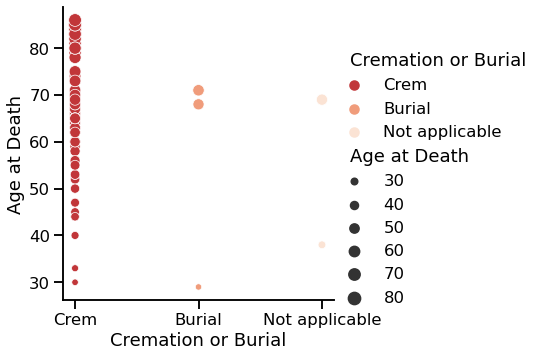

In [15]:
sns.set_context("talk")
sns.set_palette("RdBu")
sns.relplot(x="Cremation or Burial", y="Age at Death", data=df, kind="scatter", size="Age at Death", hue="Cremation or Burial")
plt.show()

So, looks like the majority of end-of-life body disposition is cremation, and most of them are between 60-90 years old. We've only got three for burial and they were around 30 and 66-73 years old.

What we could do next is see which people paid more for funeral services. We can assume 'nil' means nothing, and according to Google, 'Nil-Cost Option means a right to acquire Shares for no payment granted under the Plan'.

In [16]:
df["Cost to LA in pounds"].unique() # check values in column "Cost in LA in pounds". This will be y value

array([214, 'nil', 1002, 'Nil', 150, 187, 68, 1392, 1005, 1060, 1103,
       1216, 1167, 195, 1081, 1197, 1174, 1114, 396, 427, 346, 8, 1173,
       1369, 1247, 122.7, 3625, 1313, 1210, 1227, 1562, 1311, 1209, 'TBC',
       1234, 1637, 55, 1453, 1271, 1266, 1142.75, 1084.25, 1317, 1270,
       'Not applicable', 1339], dtype=object)

Our first issue here is that prices are not in int or float but instead object. Secondly, we have 'nil', 'Nil', 'TBC', and 'Not applicable' values. 

In [17]:
df[df["Cost to LA in pounds"]=="nil"]

,Year,Date of Birth,Date of Death,Age at Death,Gender,Next of Kin,Cost to LA in pounds,Cremation or Burial
1,2011-2012,28.09.1925,11.05.2011,85,Female,Yes,nil,Crem
8,2012-2013,13.11.1929,01.12.2012,83,Male,No,nil,Crem
9,2012-2013,19.08.1945,13.12.2012,66,Female,Yes,nil,Crem
10,2012-2013,23.07.1946,14.12.2012,66,Male,Yes,nil,Crem
14,2013-2014,02.05.1944,28.04.2013,68,Male,No,nil,Crem
17,2013-2014,30.09.1945,31.07.2013,67,Male,Yes,nil,Crem
21,2013-2014,05.06.1953,24.12.2013,60,Male,Yes,nil,Crem
26,2014-2015,28.09.1933,10.07.2014,80,Male,Yes,nil,Crem
28,2014-2015,16.04.1932,16.12.2014,82,Female,Yes,nil,Crem
32,2015-2016,24.11.1947,29.04.2015,67,Male,Yes,nil,Crem


Darn, that's a lot. Okay, let's look at 'Nil' next.

In [18]:
df[df["Cost to LA in pounds"]=="Nil"]

,Year,Date of Birth,Date of Death,Age at Death,Gender,Next of Kin,Cost to LA in pounds,Cremation or Burial
3,2011-2012,30.09.1927,22.09.2011,83,Male,No,Nil,Crem


Alright, now let's check 'TBC'.

In [19]:
df[df["Cost to LA in pounds"]=="TBC"]

,Year,Date of Birth,Date of Death,Age at Death,Gender,Next of Kin,Cost to LA in pounds,Cremation or Burial
49,2016-2017,09.09.1930,26.08.2016,85,Male,Yes,TBC,Crem
62,2017-2018,01.12.1944,07.02.2018,73,Male,Yes,TBC,Crem
63,2018-2019,10.07.1973,21.02.2018,44,Male,Yes,TBC,Crem
64,2018-2019,28.12.1942,13.04.2018,75,Female,Not known,TBC,Crem
65,2018-2019,14.06.1970,16.04.2018,47,Female,Yes,TBC,Crem
67,2018-2019,21.11.1954,06.05.2018,63,Female,Yes,TBC,Crem
68,2018-2019,04.12.1949,26.05.2018,68,Male,Yes,TBC,Crem
69,2018-2019,14.01.1958,07.05.2018,60,Male,Yes,TBC,Crem
70,2018-2019,15.04.1989,18.12.2017,29,Male,Yes,TBC,Burial
71,2018-2019,26.10.1961,17.08.2018,56,Male,Yes,TBC,Crem


This covers more than half of our data (tartar sauce!). But to find an ordered list of highest to lowest funeral costs, we need to replace these and eventually convert object to int. 

In [20]:
df = df[df["Cost to LA in pounds"] != "TBC"]
df["Cost to LA in pounds"].unique()

array([214, 'nil', 1002, 'Nil', 150, 187, 68, 1392, 1005, 1060, 1103,
       1216, 1167, 195, 1081, 1197, 1174, 1114, 396, 427, 346, 8, 1173,
       1369, 1247, 122.7, 3625, 1313, 1210, 1227, 1562, 1311, 1209, 1234,
       1637, 55, 1453, 1271, 1266, 1142.75, 1084.25, 1317, 1270,
       'Not applicable', 1339], dtype=object)

In [21]:
df = df[df["Cost to LA in pounds"] != "nil"]
df["Cost to LA in pounds"].unique()

array([214, 1002, 'Nil', 150, 187, 68, 1392, 1005, 1060, 1103, 1216, 1167,
       195, 1081, 1197, 1174, 1114, 396, 427, 346, 8, 1173, 1369, 1247,
       122.7, 3625, 1313, 1210, 1227, 1562, 1311, 1209, 1234, 1637, 55,
       1453, 1271, 1266, 1142.75, 1084.25, 1317, 1270, 'Not applicable',
       1339], dtype=object)

In [22]:
df = df[df["Cost to LA in pounds"] != "Nil"]
df["Cost to LA in pounds"].unique()

array([214, 1002, 150, 187, 68, 1392, 1005, 1060, 1103, 1216, 1167, 195,
       1081, 1197, 1174, 1114, 396, 427, 346, 8, 1173, 1369, 1247, 122.7,
       3625, 1313, 1210, 1227, 1562, 1311, 1209, 1234, 1637, 55, 1453,
       1271, 1266, 1142.75, 1084.25, 1317, 1270, 'Not applicable', 1339],
      dtype=object)

In [23]:
df = df[df["Cost to LA in pounds"] != "Not applicable"]
df["Cost to LA in pounds"].unique()

array([214, 1002, 150, 187, 68, 1392, 1005, 1060, 1103, 1216, 1167, 195,
       1081, 1197, 1174, 1114, 396, 427, 346, 8, 1173, 1369, 1247, 122.7,
       3625, 1313, 1210, 1227, 1562, 1311, 1209, 1234, 1637, 55, 1453,
       1271, 1266, 1142.75, 1084.25, 1317, 1270, 1339], dtype=object)

In [24]:
# Convert dtype from object to numeric for cost
df["Cost to LA in pounds"]= pd.to_numeric(df["Cost to LA in pounds"])
df.dtypes

Year                     object
Date of Birth            object
Date of Death            object
Age at Death              int64
Gender                   object
Next of Kin              object
Cost to LA in pounds    float64
Cremation or Burial      object
dtype: object

In [25]:
top10 = df.sort_values(by="Cost to LA in pounds",ascending=False).head(10)
print(top10)

         Year Date of Birth Date of Death  Age at Death  Gender Next of Kin  \
41  2015-2016    11.06.1947    28.03.2016            68  Female          No   
51  2016-2017    30.10.1930    30.03.2017            86  Female         Yes   
45  2016-2017    27.08.1938    15.10.2016            78    Male         Yes   
53  2017-2018    06.12.1956    02.05.2017            60    Male         Yes   
7   2012-2013    09.07.1930    11.11.2012            81    Male          No   
34  2015-2016    31.07.1950    19.06.2015            64  Female         Yes   
61  2017-2018    16.02.1947    04.12.2017            70    Male   Not known   
58  2017-2018    05.02.1948    28.08.2017            69    Male         Yes   
42  2015-2016    18.04.1956    20.03.2016            59    Male         Yes   
46  2016-2017    01.12.1952    11.10.2016            63  Female         Yes   

    Cost to LA in pounds Cremation or Burial  
41                3625.0              Burial  
51                1637.0            

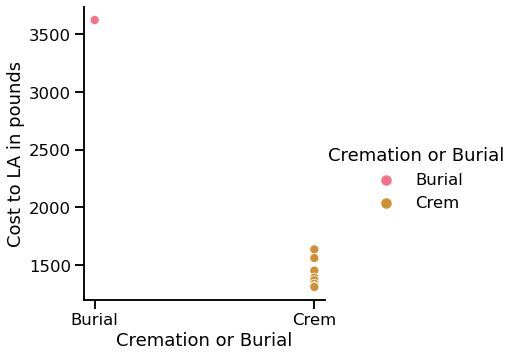

In [26]:
sns.set_palette("husl", 8)
sns.relplot(x="Cremation or Burial", y="Cost to LA in pounds", data=top10, kind="scatter", hue="Cremation or Burial")
plt.show()

It seems burying a dead body costs more than cremation, which is congruent with the findings from the articles stated earlier. Perhaps cost of burial is a leading factor for end-of-life body disposition. 

The next data contains cremations carried out in the British Islands from Dec 2019 to Dec 2020. Since our data from Calderdale Metropolitan Borough Council is of West Yorkshire, we'll narrow it down to that county.

## Part 3: Exploring other dataset

In [27]:
path2 = r'C:\Users\yuvem\OneDrive\Documents\Table_of_cremations.xlsx'
xl2 = pd.read_excel(path2) # read excel file
xl2.head()

,Crematoria,Latitude,Longtitude,1 Jan-31 Dec 2019,1 Jan-31 Dec 2020,Total Since Opening,Total for County 2020,Direct Cremations 2019,Direct Cremations 2020,January 2020 Basic Cremation Fee in pounds,January 2021 Basic Cremation Fee in pounds,Total Crematorium Charges in pounds
0,Bedford,52.155162,-0.411665,1744,1824,85432,NaN,60,52,810.8,849.95,944.5
1,Luton,51.911291,-0.389880,1565,1884,128685,3708.0,N/R,243,760.0,780.00,780.0
2,Bracknell,51.391328,-0.780324,2009,2396,69774,NaN,32,218,875.0,900.00,900.0
3,Reading,51.475829,-0.955201,1646,1898,135794,NaN,74,167,810.0,830.00,873.5
4,Slough,51.523431,-0.592800,1358,1368,89237,NaN,N/R,59,795.0,835.00,835.0


In [28]:
xl2.isna().sum() # Check null-values

Crematoria                                     0
Latitude                                       0
Longtitude                                     0
1 Jan-31 Dec 2019                              0
1 Jan-31 Dec 2020                              0
Total Since Opening                            0
Total for County 2020                         49
Direct Cremations 2019                         0
Direct Cremations 2020                         0
January 2020 Basic Cremation Fee in pounds     1
January 2021 Basic Cremation Fee in pounds     0
Total Crematorium Charges in pounds            0
dtype: int64

### Part 3a: Visualize Correlations, Distributions, and Variance

Initial cleaning and then visualization of distributions and variance. 

This dataset is for cremations in the British Islands by Calderdale Metropolitan Borough Council. We can look at binomial confidence intervals and measuring proportions. But first, we'll look into correlations.

#### Part 3.2 Cleaning

In [29]:
xl2_clean = xl2.drop(columns="Total for County 2020") # Too many null values, drop this column
xl2_clean.head()

,Crematoria,Latitude,Longtitude,1 Jan-31 Dec 2019,1 Jan-31 Dec 2020,Total Since Opening,Direct Cremations 2019,Direct Cremations 2020,January 2020 Basic Cremation Fee in pounds,January 2021 Basic Cremation Fee in pounds,Total Crematorium Charges in pounds
0,Bedford,52.155162,-0.411665,1744,1824,85432,60,52,810.8,849.95,944.5
1,Luton,51.911291,-0.389880,1565,1884,128685,N/R,243,760.0,780.00,780.0
2,Bracknell,51.391328,-0.780324,2009,2396,69774,32,218,875.0,900.00,900.0
3,Reading,51.475829,-0.955201,1646,1898,135794,74,167,810.0,830.00,873.5
4,Slough,51.523431,-0.592800,1358,1368,89237,N/R,59,795.0,835.00,835.0


In [30]:
xl2_ = xl2_clean[xl2_clean["January 2020 Basic Cremation Fee in pounds"].notna()]
xl2_.isna().sum()

Crematoria                                    0
Latitude                                      0
Longtitude                                    0
1 Jan-31 Dec 2019                             0
1 Jan-31 Dec 2020                             0
Total Since Opening                           0
Direct Cremations 2019                        0
Direct Cremations 2020                        0
January 2020 Basic Cremation Fee in pounds    0
January 2021 Basic Cremation Fee in pounds    0
Total Crematorium Charges in pounds           0
dtype: int64

In [31]:
xl2_[xl2_["Direct Cremations 2019"]=="N/R"] # Check this column. Although there's a lot of null values, we won't get rid of them. Instead we'll drop the entire column

,Crematoria,Latitude,Longtitude,1 Jan-31 Dec 2019,1 Jan-31 Dec 2020,Total Since Opening,Direct Cremations 2019,Direct Cremations 2020,January 2020 Basic Cremation Fee in pounds,January 2021 Basic Cremation Fee in pounds,Total Crematorium Charges in pounds
1,Luton,51.911291,-0.389880,1565,1884,128685,N/R,243,760.00,780.00,780.00
4,Slough,51.523431,-0.592800,1358,1368,89237,N/R,59,795.00,835.00,835.00
16,Chester,53.205277,-2.906380,1743,1941,95290,N/R,22,757.00,869.25,869.25
25,Middlesbrough,54.540611,-1.244878,2799,2241,191367,N/R,0,772.00,790.00,940.00
30,Beetham Hall,54.205204,-2.768693,973,1270,3967,N/R,N/R,975.00,975.00,975.00
32,Distington (Whitehaven),54.602835,-3.521125,1015,1269,39792,N/R,74,805.00,892.00,892.00
35,Chesterfield,53.251790,-1.405668,2094,2424,117801,N/R,105,770.00,770.00,770.00
45,Purbeck,50.747475,-2.046002,992,1401,3285,N/R,158,538.00,538.00,538.00
46,Weymouth,50.612301,-2.477066,1283,1349,76564,N/R,80,813.75,830.00,830.00
51,Wear Valley,54.659398,-1.612880,1174,1577,9685,N/R,284,884.00,884.00,929.00


In [32]:
xl2_[xl2_["Direct Cremations 2020"]=="N/R"] # We can drop this column too

,Crematoria,Latitude,Longtitude,1 Jan-31 Dec 2019,1 Jan-31 Dec 2020,Total Since Opening,Direct Cremations 2019,Direct Cremations 2020,January 2020 Basic Cremation Fee in pounds,January 2021 Basic Cremation Fee in pounds,Total Crematorium Charges in pounds
30,Beetham Hall,54.205204,-2.768693,973,1270,3967,N/R,N/R,975.0,975.0,975.0
43,Bournemouth,50.747969,-1.855952,2938,4066,260259,201,N/R,783.0,805.0,805.0


In [33]:
xl2_["January 2020 Basic Cremation Fee in pounds"].unique() # Values check

array([810.8 , 760.  , 875.  , 810.  , 795.  , 995.  , 890.  , 985.  ,
       630.  , 645.  , 960.  , 830.  , 988.  , 958.  , 757.  , 750.  ,
       786.  , 745.  , 761.  , 772.  , 999.  , 784.  , 906.  , 975.  ,
       845.  , 805.  , 729.  , 770.  , 759.  , 680.  , 915.  , 895.  ,
       783.  , 898.  , 538.  , 813.75, 700.  , 765.  , 884.  , 973.  ,
       777.  , 970.  , 850.  , 785.  , 905.  , 775.  ])

In [34]:
xl2_.shape

(62, 11)

In [35]:
xl2_.dtypes

Crematoria                                     object
Latitude                                      float64
Longtitude                                    float64
1 Jan-31 Dec 2019                               int64
1 Jan-31 Dec 2020                               int64
Total Since Opening                             int64
Direct Cremations 2019                         object
Direct Cremations 2020                         object
January 2020 Basic Cremation Fee in pounds    float64
January 2021 Basic Cremation Fee in pounds    float64
Total Crematorium Charges in pounds           float64
dtype: object

In [36]:
xl2_ = xl2_.drop(columns="Direct Cremations 2019") # Too many null values, drop this column
xl2_.head()

,Crematoria,Latitude,Longtitude,1 Jan-31 Dec 2019,1 Jan-31 Dec 2020,Total Since Opening,Direct Cremations 2020,January 2020 Basic Cremation Fee in pounds,January 2021 Basic Cremation Fee in pounds,Total Crematorium Charges in pounds
0,Bedford,52.155162,-0.411665,1744,1824,85432,52,810.8,849.95,944.5
1,Luton,51.911291,-0.389880,1565,1884,128685,243,760.0,780.00,780.0
2,Bracknell,51.391328,-0.780324,2009,2396,69774,218,875.0,900.00,900.0
3,Reading,51.475829,-0.955201,1646,1898,135794,167,810.0,830.00,873.5
4,Slough,51.523431,-0.592800,1358,1368,89237,59,795.0,835.00,835.0


In [37]:
xl2_ = xl2_.drop(columns="Direct Cremations 2020") # Too many null values, drop this column
xl2_.head()

,Crematoria,Latitude,Longtitude,1 Jan-31 Dec 2019,1 Jan-31 Dec 2020,Total Since Opening,January 2020 Basic Cremation Fee in pounds,January 2021 Basic Cremation Fee in pounds,Total Crematorium Charges in pounds
0,Bedford,52.155162,-0.411665,1744,1824,85432,810.8,849.95,944.5
1,Luton,51.911291,-0.389880,1565,1884,128685,760.0,780.00,780.0
2,Bracknell,51.391328,-0.780324,2009,2396,69774,875.0,900.00,900.0
3,Reading,51.475829,-0.955201,1646,1898,135794,810.0,830.00,873.5
4,Slough,51.523431,-0.592800,1358,1368,89237,795.0,835.00,835.0


#### Part 3.3: Analyzing correlations

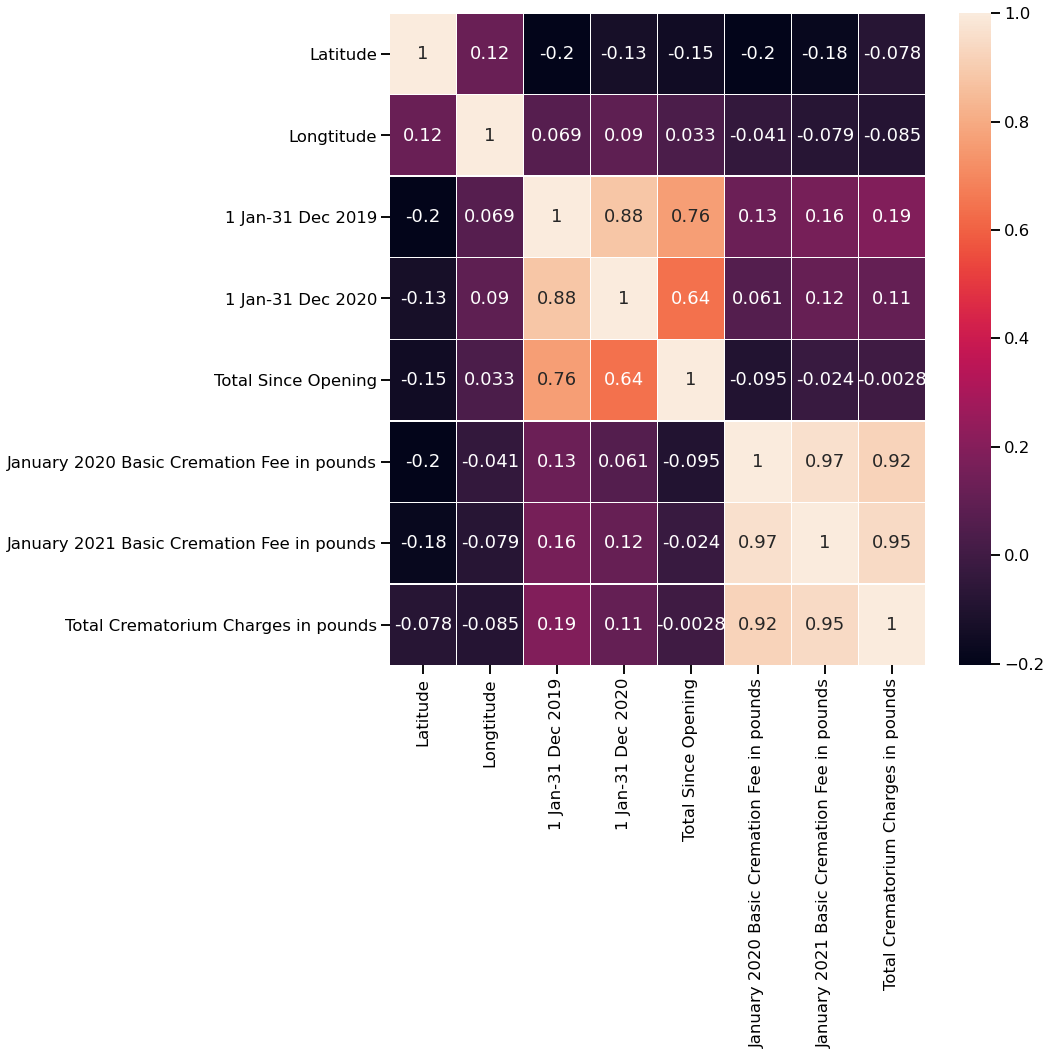

In [38]:
# Make heatmap of data
_= plt.figure(figsize=(12,12))
heatmap = sns.heatmap(xl2_.corr(), annot=True, linewidth=0.4)
plt.show()

From here we can see there's a relatively strong correlation between 1 Jan-31 Dec 2020 and Total Since Opening, as well as for 1 Jan-31 Dec 2019 and Total Since Opening. We want our variables to be '1 Jan-31 Dec 2019' and 'January 2020 Basic Cremation Fee in pounds'. We can make more visualization of correlations using pairplot.

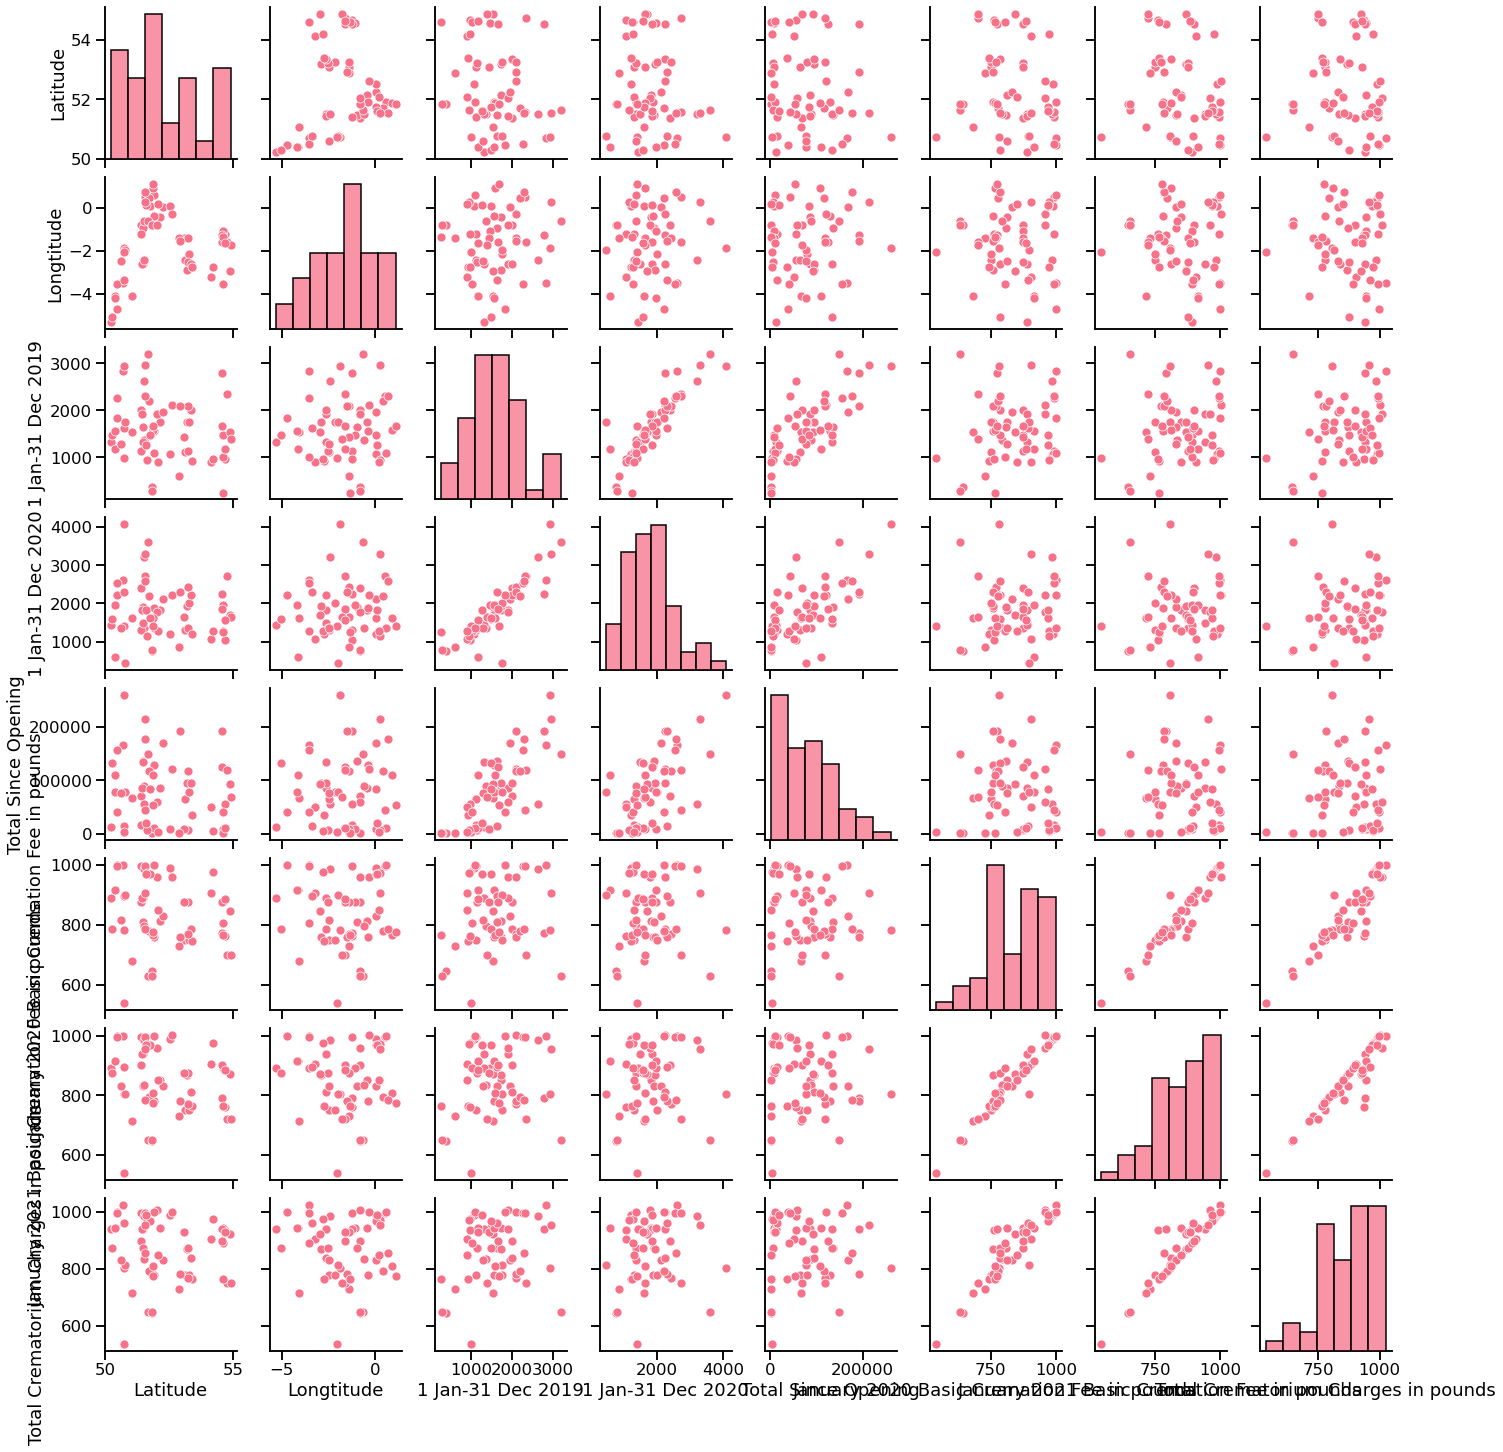

In [39]:
sns.pairplot(xl2_)

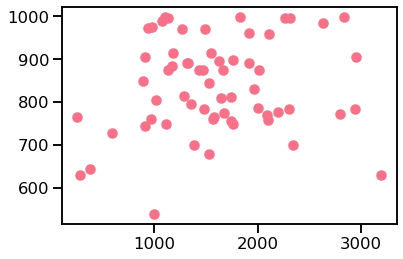

In [40]:
_= plt.scatter(xl2_['1 Jan-31 Dec 2019'], xl2_['January 2020 Basic Cremation Fee in pounds'])
plt.show()

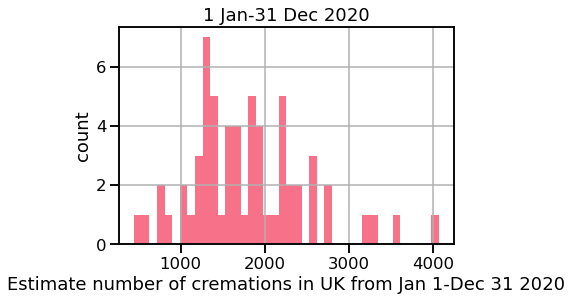

In [79]:
# Visualize distributions for x variable
xl2_[['1 Jan-31 Dec 2020']].hist(bins=40)
plt.xlabel('Estimate number of cremations in UK from Jan 1-Dec 31 2020')
plt.ylabel('count');

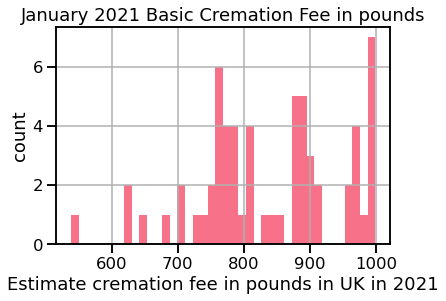

In [80]:
# Visualize distribution for y variable
xl2_[['January 2021 Basic Cremation Fee in pounds']].hist(bins=40)
plt.xlabel('Estimate cremation fee in pounds in UK in 2021')
plt.ylabel('count');

#### Part 3.4 Converting float to int

In [81]:
xl2_['January 2020 Basic Cremation Fee in pounds'] = xl2_['January 2020 Basic Cremation Fee in pounds'].astype(int)
xl2_['January 2021 Basic Cremation Fee in pounds'] = xl2_['January 2020 Basic Cremation Fee in pounds'].astype(int)
xl2_['Total Crematorium Charges in pounds'] = xl2_['January 2020 Basic Cremation Fee in pounds'].astype(int)
xl2_.dtypes

Crematoria                                     object
Latitude                                      float64
Longtitude                                    float64
1 Jan-31 Dec 2019                               int64
1 Jan-31 Dec 2020                               int64
Total Since Opening                             int64
January 2020 Basic Cremation Fee in pounds      int32
January 2021 Basic Cremation Fee in pounds      int32
Total Crematorium Charges in pounds             int32
dtype: object

#### Part 3.5 Scaling data

In [82]:
# Create new dataframe 
xl2_scaled = xl2_.set_index('Crematoria')
# Save Crematoria labels
xl2_index = xl2_scaled.index
# Save column names
xl2_columns = xl2_scaled.columns
xl2_scaled.head()

,Latitude,Longtitude,1 Jan-31 Dec 2019,1 Jan-31 Dec 2020,Total Since Opening,January 2020 Basic Cremation Fee in pounds,January 2021 Basic Cremation Fee in pounds,Total Crematorium Charges in pounds
Crematoria,,,,,,,,
Bedford,52.155162,-0.411665,1744,1824,85432,810,810,810
Luton,51.911291,-0.389880,1565,1884,128685,760,760,760
Bracknell,51.391328,-0.780324,2009,2396,69774,875,875,875
Reading,51.475829,-0.955201,1646,1898,135794,810,810,810
Slough,51.523431,-0.592800,1358,1368,89237,795,795,795


In [83]:
xl2_index

Index(['Bedford', 'Luton', 'Bracknell', 'Reading', 'Slough',
       'West Berkshire (Thatcham)', 'Bristol (Canford)', 'Bristol (South)',
       'Westerleigh', 'Amersham (Chilterns)', 'Aylesbury Vale', 'Bierton',
       'Milton Keynes', 'Cambridge', 'March (Fenland)', 'Peterborough',
       'Chester', 'Crewe', 'Macclesfield', 'Northwich', 'Warrington', 'Widnes',
       'Hartlepool', 'Kirkleatham', 'Middlesbrough', 'Bodmin', 'Camborne',
       'Truro', 'Barrow-in-Furness', 'Beetham Hall', 'Carlisle',
       'Distington (Whitehaven)', 'Alfreton (Amber Valley)',
       'Aston-on-Trent (Trent Valley) ', 'Chesterfield', 'Derby', 'Barnstaple',
       'Exeter & Devon', 'Plymouth (Efford)', 'Plymouth (Weston Mill)',
       'Torquay', 'Whimple (East Devon)', 'Bournemouth', 'Poole', 'Purbeck',
       'Weymouth', 'Darlington', 'Durham', 'Mountsett', 'Stockton-on-Tees',
       'Wear Valley', 'Basildon', 'Braintree', 'Brentwood', 'Chelmsford',
       'Colchester', 'Harlow', 'Redbridge (Forest Park)'

In [84]:
xl2_columns

Index(['Latitude', 'Longtitude', '1 Jan-31 Dec 2019', '1 Jan-31 Dec 2020',
       'Total Since Opening', 'January 2020 Basic Cremation Fee in pounds',
       'January 2021 Basic Cremation Fee in pounds',
       'Total Crematorium Charges in pounds'],
      dtype='object')

In [85]:
xl2_scaled = scale(xl2_scaled)

In [86]:
xl2_scaled
type(xl2_scaled)

numpy.ndarray

In [87]:
year2019_mean = xl2_['1 Jan-31 Dec 2020'].mean()
year2019_std = xl2_['1 Jan-31 Dec 2020'].std()
print(year2019_mean)
print(year2019_std)
print((3-year2019_mean)/year2019_std)

1801.9354838709678
703.3621801214307
-2.557623276759626


In [88]:
# Create a new df from xl2_scaled using column names saved in xl2_columns
xl2_scaled_df = pd.DataFrame(xl2_scaled, columns= xl2_columns)
xl2_scaled_df.head()
# This will be training set

,Latitude,Longtitude,1 Jan-31 Dec 2019,1 Jan-31 Dec 2020,Total Since Opening,January 2020 Basic Cremation Fee in pounds,January 2021 Basic Cremation Fee in pounds,Total Crematorium Charges in pounds
0,-0.104113,0.787455,0.232494,0.031626,0.129274,-0.262455,-0.262455,-0.262455
1,-0.279355,0.801532,-0.045517,0.117627,0.827960,-0.725260,-0.725260,-0.725260
2,-0.652994,0.549239,0.644076,0.851502,-0.123657,0.339191,0.339191,0.339191
3,-0.592273,0.436238,0.080287,0.137694,0.942794,-0.262455,-0.262455,-0.262455
4,-0.558067,0.670411,-0.367016,-0.621981,0.190738,-0.401297,-0.401297,-0.401297


#### Part 3.6 Verify scaling

In [89]:
xl2_scaled_df.mean()

Latitude                                      1.747706e-15
Longtitude                                    1.002782e-16
1 Jan-31 Dec 2019                             8.147604e-17
1 Jan-31 Dec 2020                            -7.162729e-17
Total Since Opening                           5.909252e-17
January 2020 Basic Cremation Fee in pounds   -1.969751e-16
January 2021 Basic Cremation Fee in pounds   -1.969751e-16
Total Crematorium Charges in pounds          -1.969751e-16
dtype: float64

In [90]:
# check std
xl2_scaled_df.std()

Latitude                                      1.008163
Longtitude                                    1.008163
1 Jan-31 Dec 2019                             1.008163
1 Jan-31 Dec 2020                             1.008163
Total Since Opening                           1.008163
January 2020 Basic Cremation Fee in pounds    1.008163
January 2021 Basic Cremation Fee in pounds    1.008163
Total Crematorium Charges in pounds           1.008163
dtype: float64

This is not bad at all! The std() method defaults to using ddof=1, that is it's normalized by N-1. Essentially, the std() method default is to assume you want your best estimate of the population parameter based on the given sample.

In [91]:
# Return biased estimate
xl2_scaled_df.std(ddof = 0)

Latitude                                      1.0
Longtitude                                    1.0
1 Jan-31 Dec 2019                             1.0
1 Jan-31 Dec 2020                             1.0
Total Since Opening                           1.0
January 2020 Basic Cremation Fee in pounds    1.0
January 2021 Basic Cremation Fee in pounds    1.0
Total Crematorium Charges in pounds           1.0
dtype: float64

#### Part 3.7 PCA Transformation

In [92]:
crematoria_pca = PCA().fit(xl2_scaled)

In [93]:
pc1= crematoria_pca.components_[0]
print(pc1)

[ 0.19119158  0.02853291 -0.20361547 -0.16003356 -0.06092272 -0.54523697
 -0.54523697 -0.54523697]


In [94]:
crematoria_pca.components_ #This is a linear combo of the 6 columns in the data

array([[ 1.91191583e-01,  2.85329131e-02, -2.03615466e-01,
        -1.60033558e-01, -6.09227242e-02, -5.45236975e-01,
        -5.45236975e-01, -5.45236975e-01],
       [-1.06990281e-01,  7.29680093e-02,  5.61969491e-01,
         5.44600301e-01,  5.46726578e-01, -1.54832815e-01,
        -1.54832815e-01, -1.54832815e-01],
       [-5.63052469e-01, -8.11447770e-01, -3.03827417e-02,
        -7.99094931e-02,  4.92972032e-02, -7.02034712e-02,
        -7.02034712e-02, -7.02034712e-02],
       [ 7.94179879e-01, -5.76405236e-01,  8.61418107e-02,
         1.18586673e-01,  7.46693248e-02,  5.76674494e-02,
         5.76674494e-02,  5.76674494e-02],
       [-5.87638341e-02, -5.62538385e-02,  1.45599410e-01,
         5.88237456e-01, -7.85701395e-01, -5.42621501e-02,
        -5.42621501e-02, -5.42621501e-02],
       [ 2.82118222e-02, -2.56293957e-03,  7.83063422e-01,
        -5.57967868e-01, -2.68413984e-01, -2.96366514e-02,
        -2.96366514e-02, -2.96366514e-02],
       [ 0.00000000e+00,  3.497076

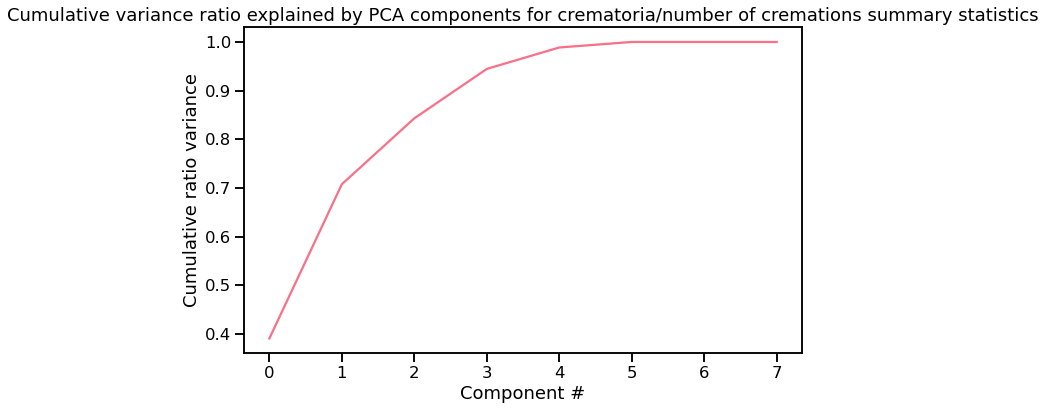

In [95]:
# Plot cumulative variance ratio of number of components
plt.subplots(figsize=(10, 6))
plt.plot(crematoria_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for crematoria/number of cremations summary statistics');

The first component seem to account for over 90% of the variance, and at the second for over 95%.

Apply the transformation to the data to obtain derived features.

In [96]:
crematoria_pca_x = crematoria_pca.transform(xl2_scaled)
# the transform is what formally applies the fit model to the state_pca. The result of .transform 
#is 6 principle components that are essentially linear combinations of the independent variables.

In [97]:
crematoria_pca_x.shape

(62, 8)

#### Part 3.8 Plot first two principle components (first two derived features)

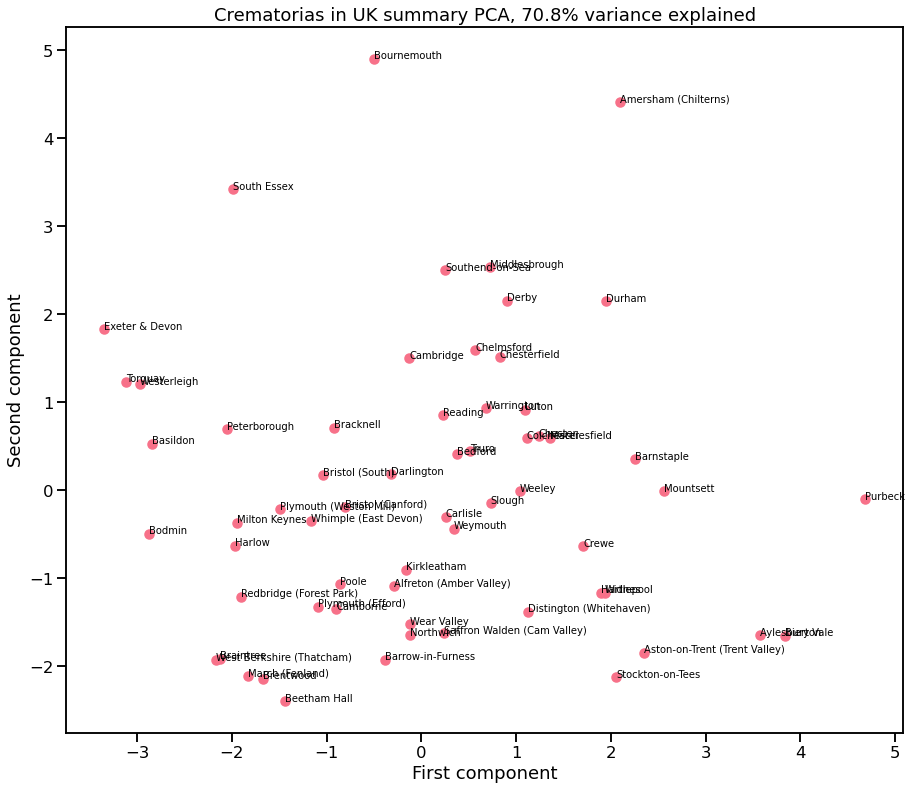

In [98]:
x = crematoria_pca_x[:, 0]
y = crematoria_pca_x[:, 1]
crematoria = xl2_index
pc_var = 100 * crematoria_pca.explained_variance_ratio_.cumsum()[1]
plt.subplots(figsize=(15,13))
plt.scatter(x=x, y=y)
plt.xlabel('First component')
plt.ylabel('Second component')
plt.title(f'Crematorias in UK summary PCA, {pc_var:.1f}% variance explained')
for s, x, y in zip((xl2_['Crematoria']), x, y):
    plt.annotate(s, (x, y))

In [99]:
crematoria_fee = xl2_.groupby(by = 'Crematoria')['January 2021 Basic Cremation Fee in pounds'].mean()
crematoria_fee.head()

Crematoria
Alfreton (Amber Valley)           875
Amersham (Chilterns)              630
Aston-on-Trent (Trent Valley)     729
Aylesbury Vale                    645
Barnstaple                        680
Name: January 2021 Basic Cremation Fee in pounds, dtype: int32

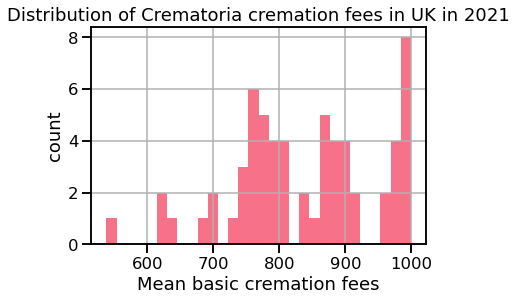

In [100]:
crematoria_fee.hist(bins=30)
plt.title('Distribution of Crematoria cremation fees in UK in 2021')
plt.xlabel('Mean basic cremation fees')
plt.ylabel('count');

#### Part 2.9 Adding basic cremation fees to scatter plot

In [101]:
pca_df = pd.DataFrame({'PC1': crematoria_pca_x[:,0], 'PC2': crematoria_pca_x[:,1]}, index= xl2_index)
pca_df.head()

,PC1,PC2
Crematoria,,
Bedford,0.371587,0.409064
Luton,1.095778,0.916405
Bracknell,-0.923873,0.710460
Reading,0.232689,0.852667
Slough,0.731484,-0.145673


In [102]:
# Cast it to dataframe
crematoria_fee.to_frame().head()

,January 2021 Basic Cremation Fee in pounds
Crematoria,
Alfreton (Amber Valley),875
Amersham (Chilterns),630
Aston-on-Trent (Trent Valley),729
Aylesbury Vale,645
Barnstaple,680


In [103]:
# Concatenate both on axis 1 and indexing
pca_df = pd.concat([pca_df, crematoria_fee], axis= 1)
pca_df.head()

,PC1,PC2,January 2021 Basic Cremation Fee in pounds
Bedford,0.371587,0.409064,810
Luton,1.095778,0.916405,760
Bracknell,-0.923873,0.710460,875
Reading,0.232689,0.852667,810
Slough,0.731484,-0.145673,795


In [104]:
# Add Quartile column to see quartiles
pca_df['Quartile'] = pd.qcut(pca_df['January 2021 Basic Cremation Fee in pounds'], q=4, precision=1)
pca_df.head(35)

,PC1,PC2,January 2021 Basic Cremation Fee in pounds,Quartile
Bedford,0.371587,0.409064,810,"(765.0, 837.5]"
Luton,1.095778,0.916405,760,"(537.9, 765.0]"
Bracknell,-0.923873,0.710460,875,"(837.5, 912.8]"
Reading,0.232689,0.852667,810,"(765.0, 837.5]"
Slough,0.731484,-0.145673,795,"(765.0, 837.5]"
West Berkshire (Thatcham),-2.164264,-1.930419,995,"(912.8, 999.0]"
Bristol (Canford),-0.809133,-0.187112,890,"(837.5, 912.8]"
Bristol (South),-1.036641,0.177430,890,"(837.5, 912.8]"
Westerleigh,-2.974089,1.205350,985,"(912.8, 999.0]"
Amersham (Chilterns),2.097532,4.414986,630,"(537.9, 765.0]"


In [105]:
pca_df.dtypes

PC1                                            float64
PC2                                            float64
January 2021 Basic Cremation Fee in pounds       int32
Quartile                                      category
dtype: object

In [106]:
# Check for nulls
pca_df[pca_df.isnull().any(axis=1)]

,PC1,PC2,January 2021 Basic Cremation Fee in pounds,Quartile


No nulls! 

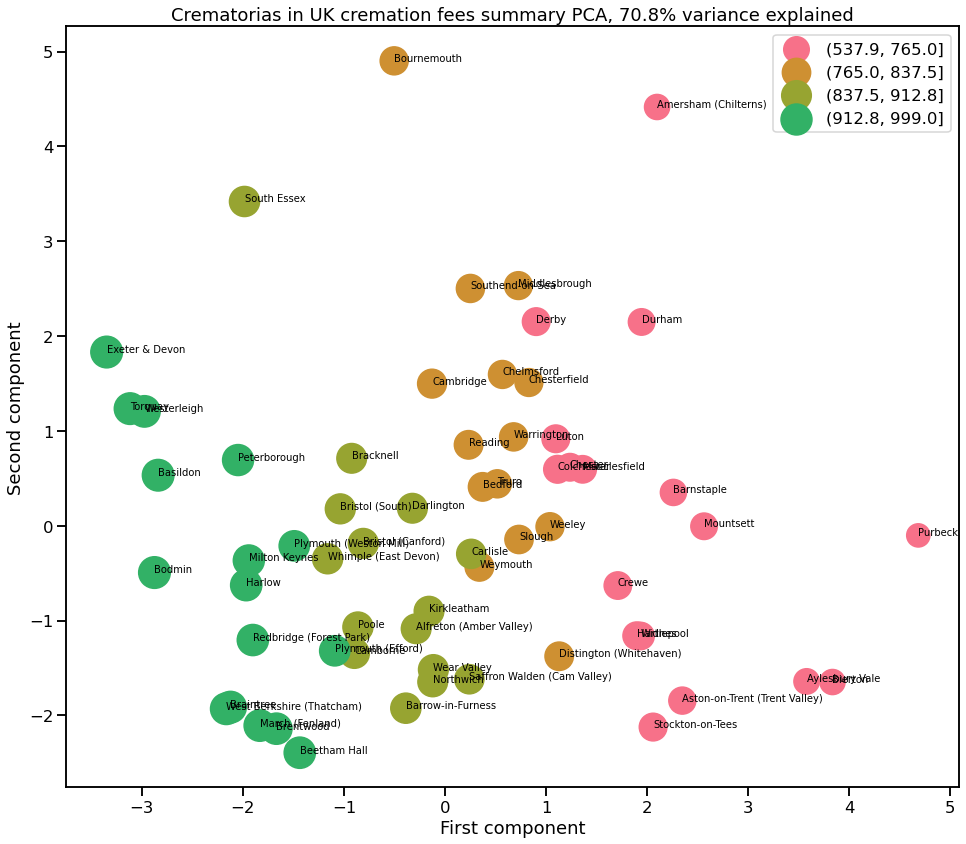

In [107]:
# Recreate scatterplot
x = pca_df.PC1
y = pca_df.PC2
price = pca_df['January 2021 Basic Cremation Fee in pounds']
quartiles = pca_df.Quartile
crematoria = pca_df.index
pc_var = 100 * crematoria_pca.explained_variance_ratio_.cumsum()[1]
fig, ax = plt.subplots(figsize=(16,14))
for q in quartiles.cat.categories:
    im = quartiles == q
    ax.scatter(x=x[im], y=y[im], s=price[im], label=q)
ax.set_xlabel('First component')
ax.set_ylabel('Second component')
plt.legend()
ax.set_title(f'Crematorias in UK cremation fees summary PCA, {pc_var:.1f}% variance explained')
for s, x, y in zip((xl2_['Crematoria']), x, y):
    plt.annotate(s, (x, y))

Okay, so here we have information about the average cremation fees in 2020. There's a pattern here! Green points represeting upper quartile prices are all to the left, olive green and brown in the middle, and pink to the right. A majority lie within the first component. Let's use seaborn next.

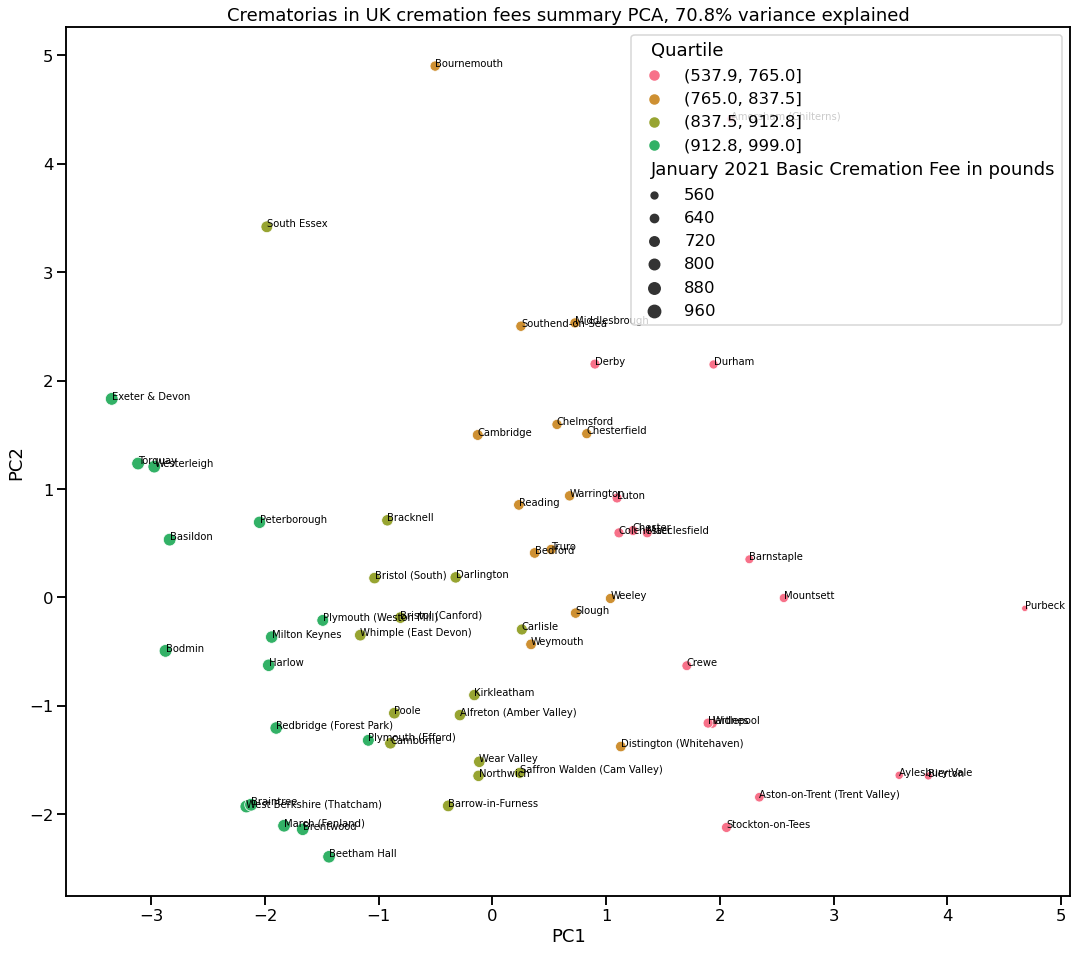

In [108]:
x = pca_df.PC1
y = pca_df.PC2
state = pca_df.index
plt.subplots(figsize=(18, 16))

sns.scatterplot(x='PC1', y='PC2', size='January 2021 Basic Cremation Fee in pounds', hue='Quartile', 
                hue_order=pca_df.Quartile.cat.categories, data=pca_df)
#and we can still annotate with the state labels
for s, x, y in zip((xl2_['Crematoria']), x, y):
    plt.annotate(s, (x, y))   
plt.title(f'Crematorias in UK cremation fees summary PCA, {pc_var:.1f}% variance explained');

Cool! So most of the average cremation fees in 2020 are up around 800-960 pounds. Sheesh!

In [109]:
pd.DataFrame(crematoria_pca.components_, columns=xl2_columns)

,Latitude,Longtitude,1 Jan-31 Dec 2019,1 Jan-31 Dec 2020,Total Since Opening,January 2020 Basic Cremation Fee in pounds,January 2021 Basic Cremation Fee in pounds,Total Crematorium Charges in pounds
0,0.191192,2.853291e-02,-2.036155e-01,-1.600336e-01,-6.092272e-02,-0.545237,-0.545237,-0.545237
1,-0.106990,7.296801e-02,5.619695e-01,5.446003e-01,5.467266e-01,-0.154833,-0.154833,-0.154833
2,-0.563052,-8.114478e-01,-3.038274e-02,-7.990949e-02,4.929720e-02,-0.070203,-0.070203,-0.070203
3,0.794180,-5.764052e-01,8.614181e-02,1.185867e-01,7.466932e-02,0.057667,0.057667,0.057667
4,-0.058764,-5.625384e-02,1.455994e-01,5.882375e-01,-7.857014e-01,-0.054262,-0.054262,-0.054262
5,0.028212,-2.562940e-03,7.830634e-01,-5.579679e-01,-2.684140e-01,-0.029637,-0.029637,-0.029637
6,0.000000,3.497077e-17,2.215106e-15,-1.007302e-15,-1.483869e-15,0.816387,-0.396602,-0.419784
7,-0.000000,2.098246e-16,2.848015e-16,-9.450584e-18,-2.063089e-16,-0.013384,0.713704,-0.700320


## Part 4: Scatterplotting

In [111]:
def scatterplots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'January 2021 Basic Cremation Fee in pounds', data=xl2_, alpha=0.5)
        ax.set(xlabel=col, ylabel='Cremation fee')
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [112]:
#Use a list comprehension to build a list of features from the columns of `xl2_` that
#are _not_ any of 'Crematoria' or 'January 2020 Basic Cremation Fee in pounds'
features = [feature for feature in xl2_.columns if feature not in ['Crematoria', 'Total Since Opening','January 2020 Basic Cremation Fee in pounds']]

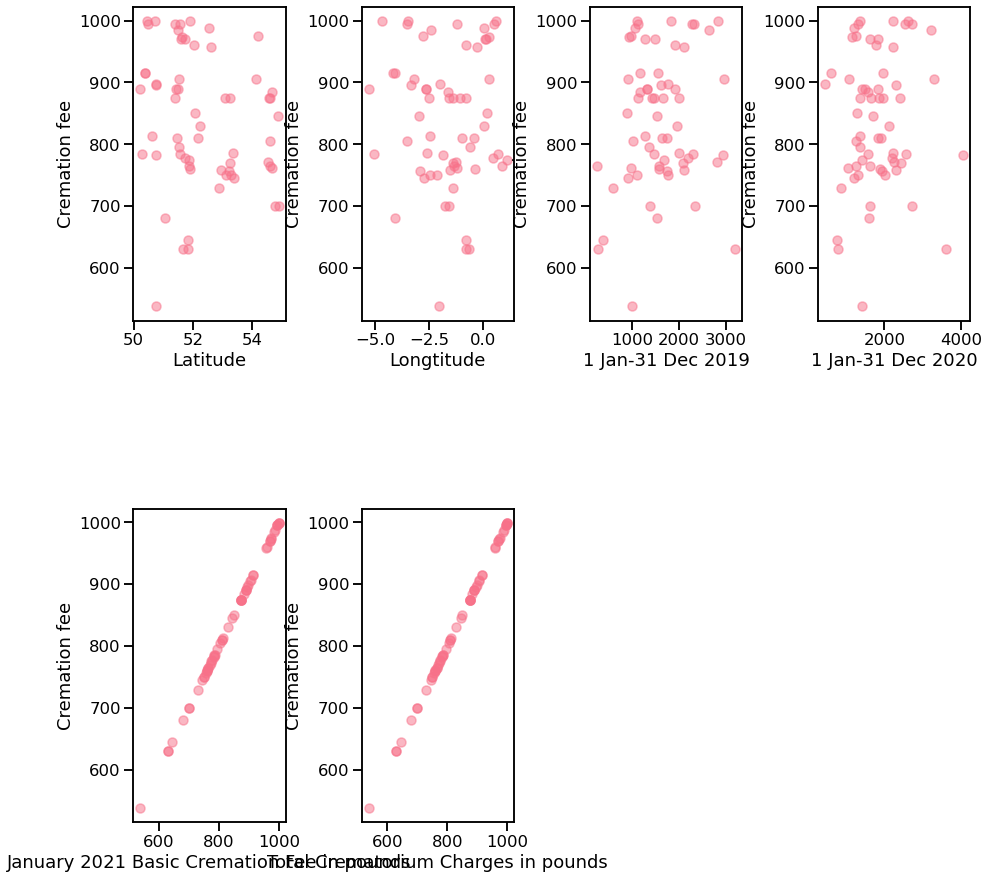

In [113]:
scatterplots(features, ncol=4, figsize=(15, 15))

Cremation fees are very positively correlated to Jan 2021 Basic Cremation Fee  and Total Cremation Charges, which makes sense. 

##  Part 4: Mapping Analysis

In this portion, we're going to do some more sophisticated visualization. Using Tableau, we can map our measures and features. The dots show the locations of the crematorias. The color scale shows January 2021 Basic Cremation Fee (in pounds), where the darker the shade of red the higher the fee. Th size of the dots emphasizes number of cremations from Jan1-Dec 31 of 2020. 

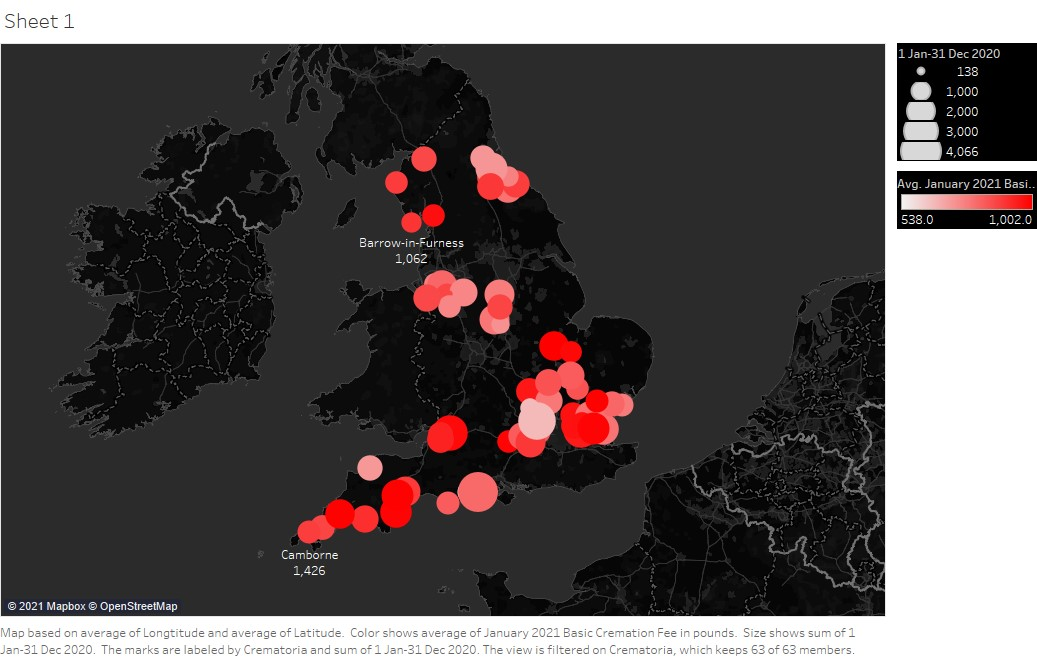

In [114]:
from IPython.display import Image
Image(r"C:\Users\yuvem\OneDrive\Documents\GitHub\Capstone-Traditional-vs-Nontraditional-Burial-Analysis\mapped_crematoria.jpg")

We zoom in to get a closer look at this, starting from the North to the South. 

### Northwest England

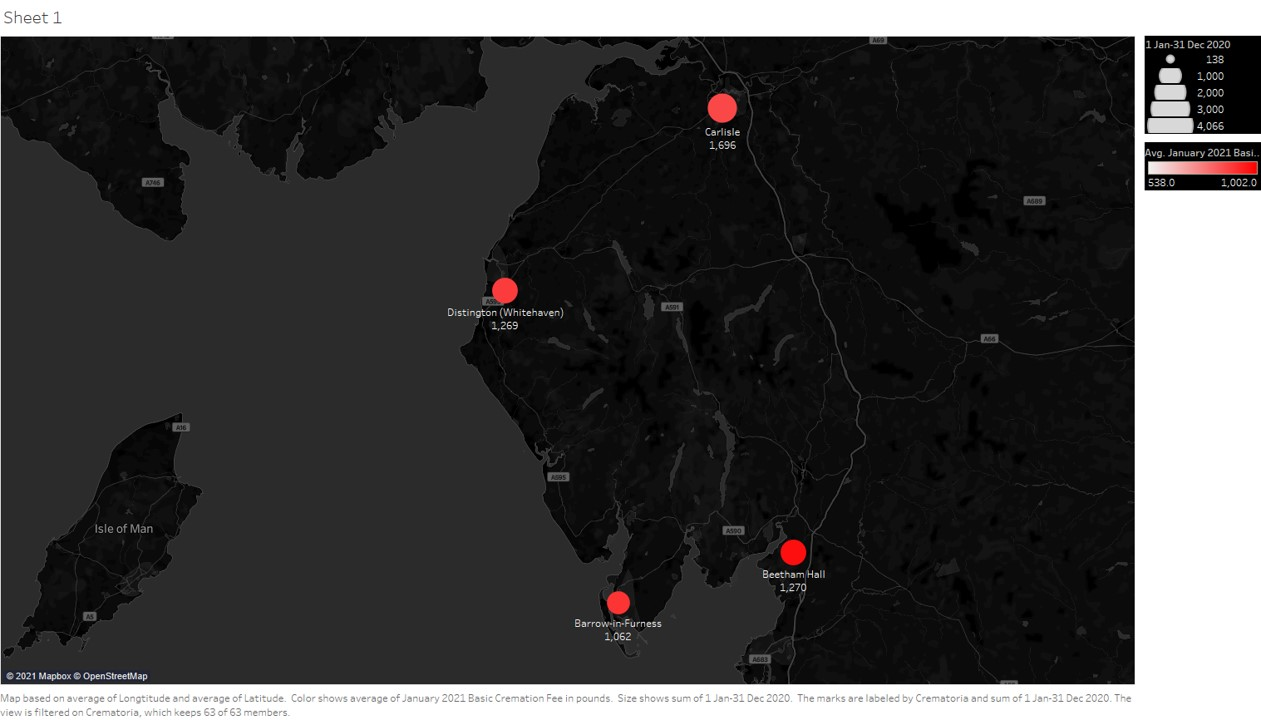

In [115]:
from IPython.display import Image
Image(r"C:\Users\yuvem\OneDrive\Documents\GitHub\Capstone-Traditional-vs-Nontraditional-Burial-Analysis\NW_england.jpg")

### Northeast England

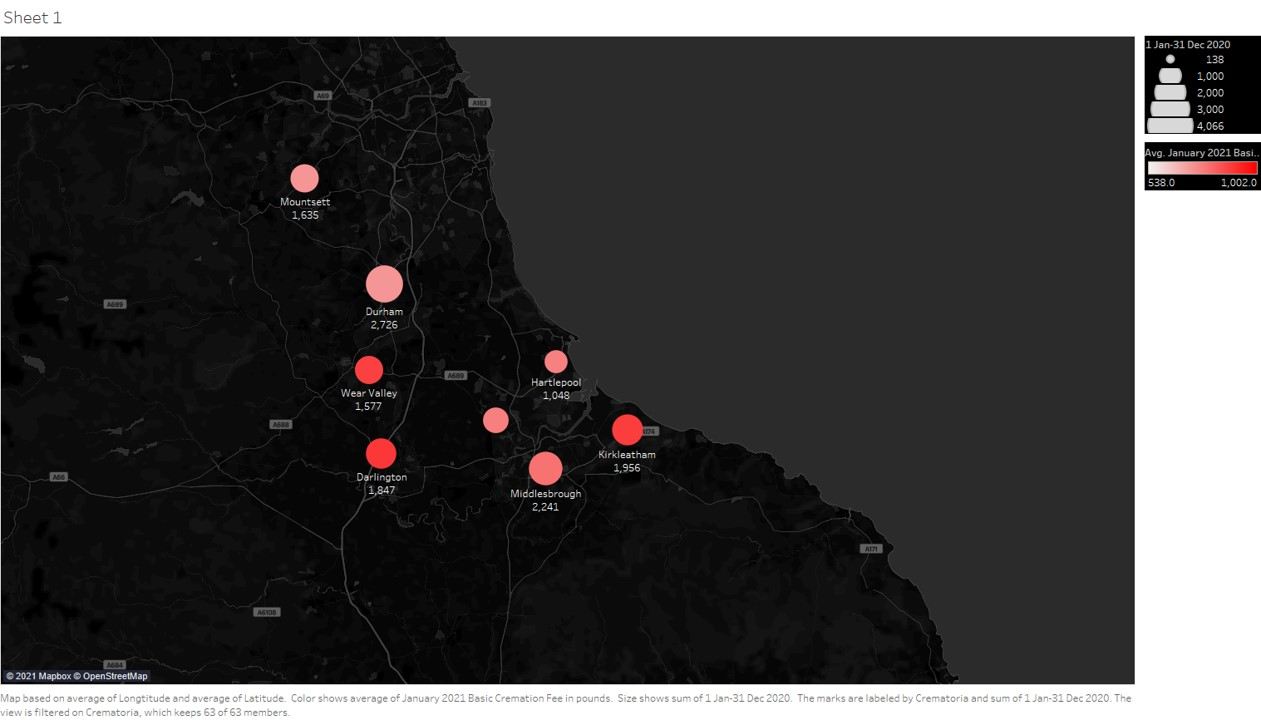

In [116]:
from IPython.display import Image
Image(r"C:\Users\yuvem\OneDrive\Documents\GitHub\Capstone-Traditional-vs-Nontraditional-Burial-Analysis\NE_england.jpg")

### Central England

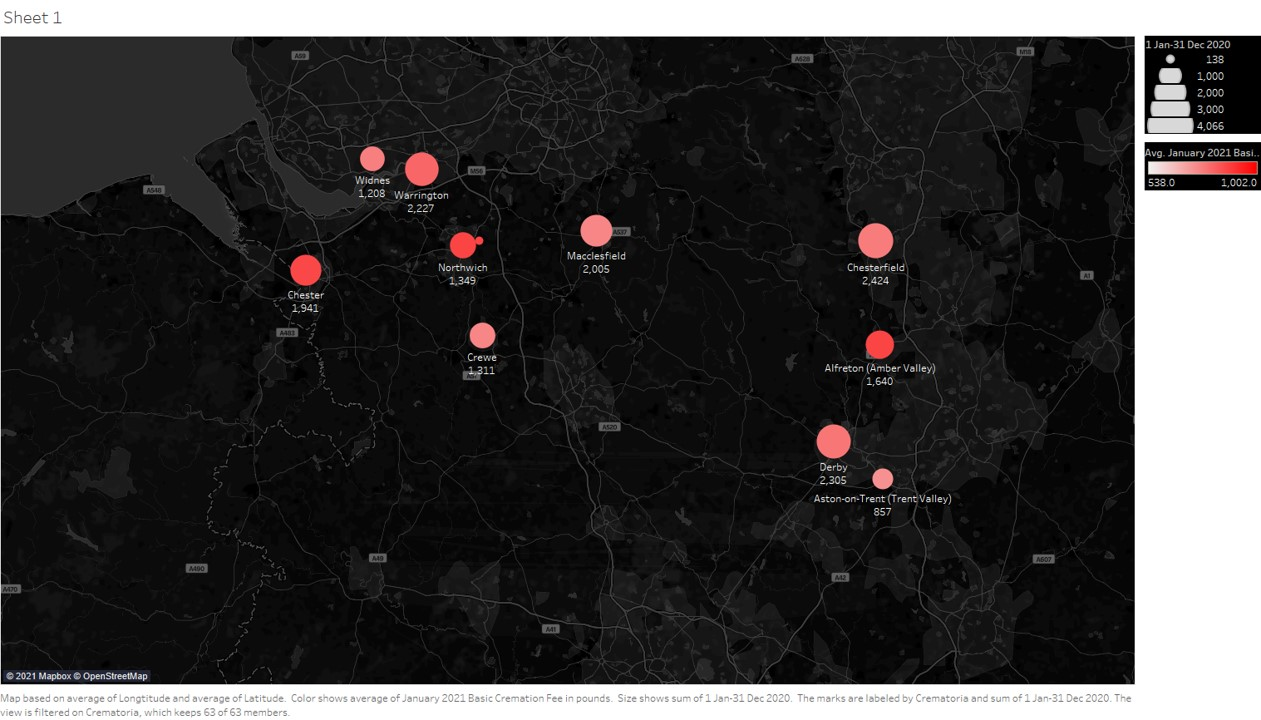

In [117]:
from IPython.display import Image
Image(r"C:\Users\yuvem\OneDrive\Documents\GitHub\Capstone-Traditional-vs-Nontraditional-Burial-Analysis\Central_england.jpg")

### Southwest England

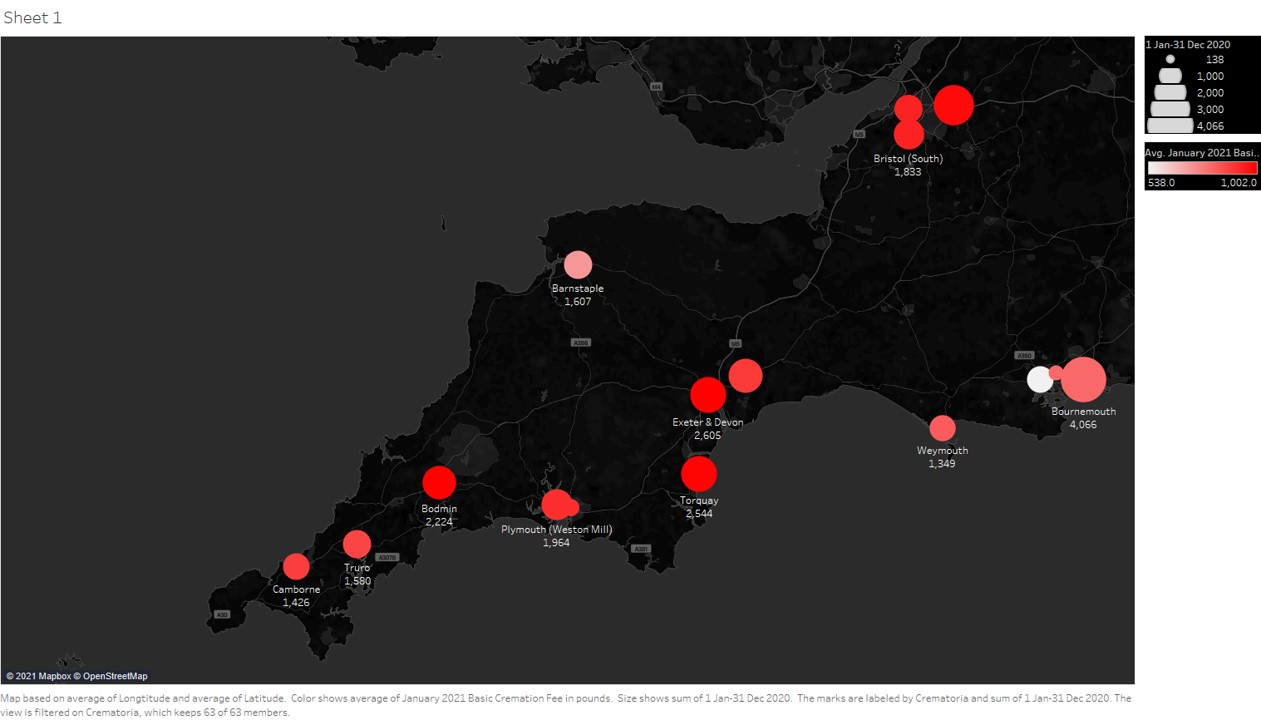

In [118]:
from IPython.display import Image
Image(r"C:\Users\yuvem\OneDrive\Documents\GitHub\Capstone-Traditional-vs-Nontraditional-Burial-Analysis\SW_england.jpg")

### Southeast England

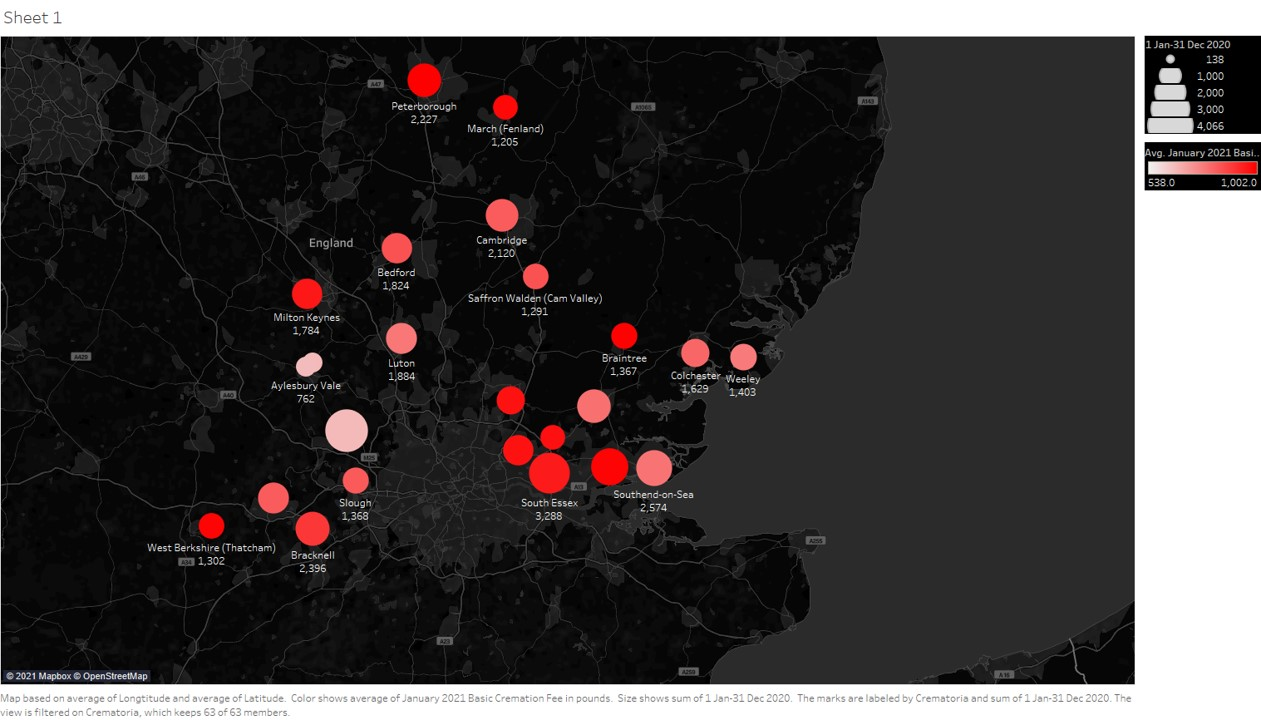

In [119]:
from IPython.display import Image
Image(r"C:\Users\yuvem\OneDrive\Documents\GitHub\Capstone-Traditional-vs-Nontraditional-Burial-Analysis\SE_england.jpg")

If we want to get a better understanding of the volume of cremations, we can map just that. Here we use density to map number of cremations from Jan1-Dec 31 of 2020.

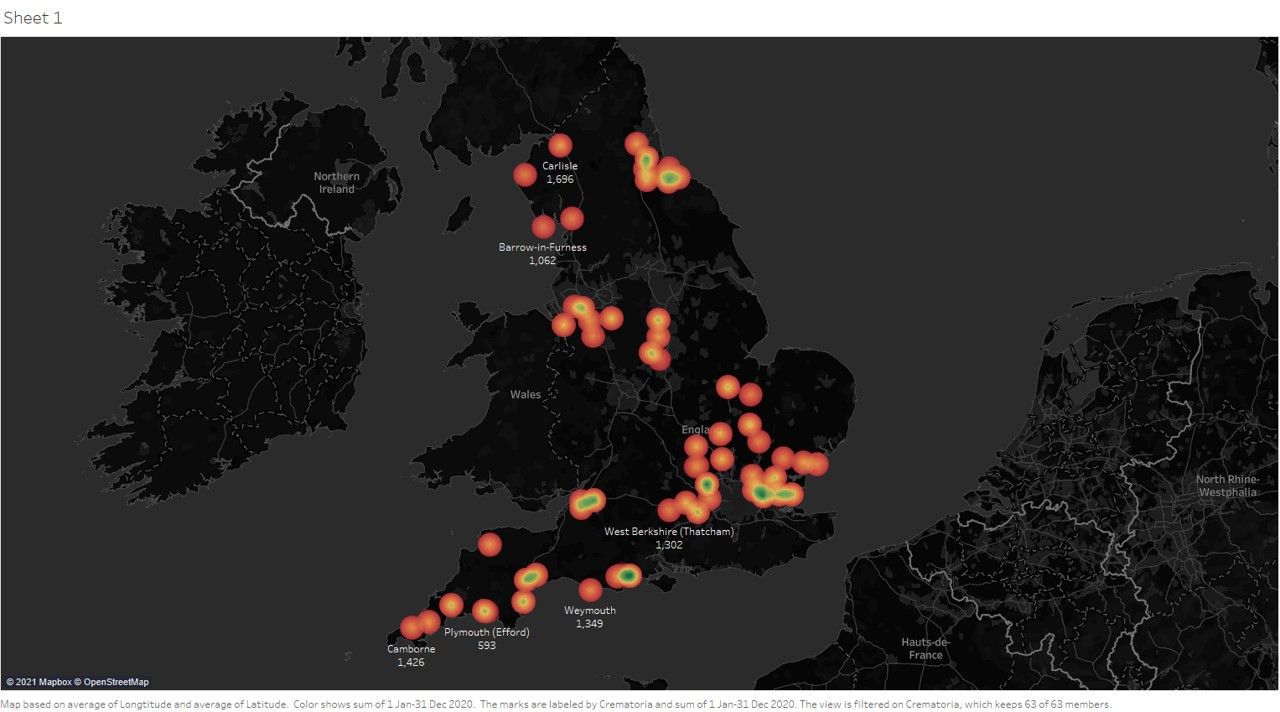

In [145]:
from IPython.display import Image
Image(r"C:\Users\yuvem\OneDrive\Documents\GitHub\Capstone-Traditional-vs-Nontraditional-Burial-Analysis\cremations_2020.jpg")

## Part 5: Treemap

We'll use Tableau's treemap to know which Crematoria in which district in the UK had the highest basic (average) cremation fees in January 2021 and the most cremations in 2020. 

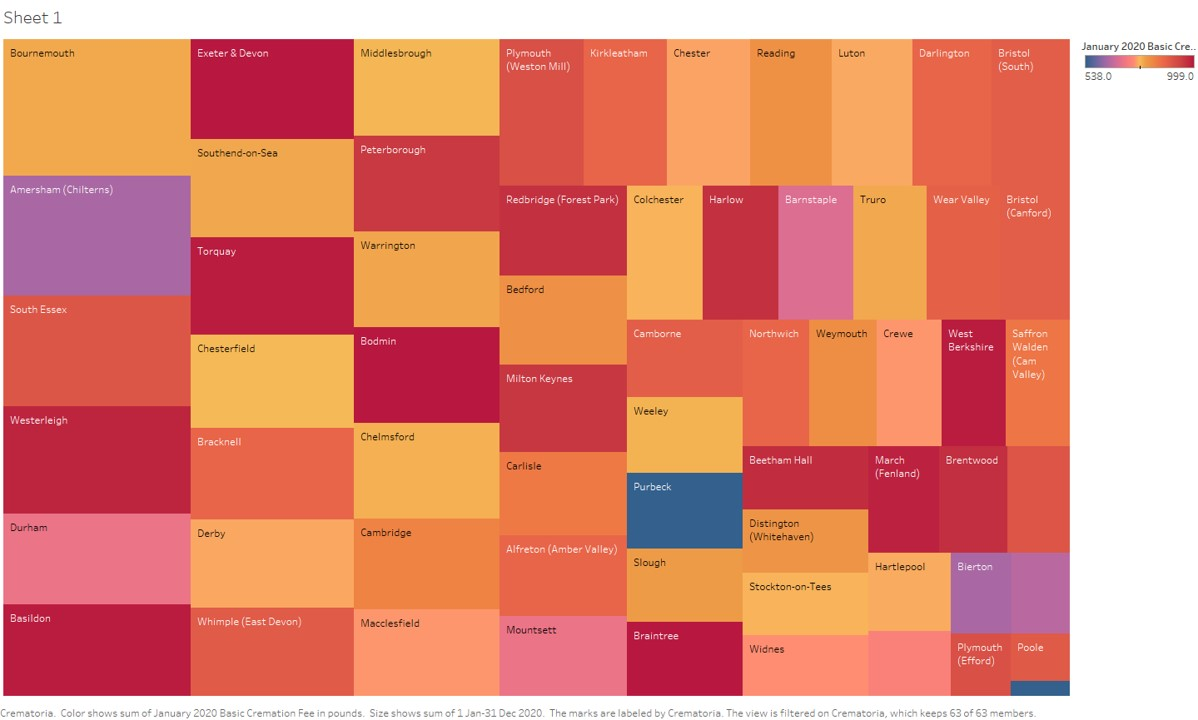

In [144]:
from IPython.display import Image
Image(r"C:\Users\yuvem\OneDrive\Documents\GitHub\Capstone-Traditional-vs-Nontraditional-Burial-Analysis\Treemap.jpg")

According to this, Bournemouth had the most cremations in 2020 and Lach Dennis (Birches Remembrance Park & Crematorium) had the least. Based on the scale at the top right, Exter & Devon, Torquay, Bodmin, West Berkshire, March (Fenland), Westerleigh, Basildon, and Braintree have the highest cremation fees in January 2021. Vice versa, Purbeck, Lach Dennis, Amersham (Chilterns), Bierton, and Aylesbury Vale had the lowest cremation fees. 